# Preprocessing

In [1]:
!pip3 install pandas_datareader
!pip install yfinance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import pandas_datareader.data as pdr

### Select the tickers and timeframe

In [3]:
tickers =  ["AAPL", "GE", "JPM", "MSFT", "VOD", "NKE", "NVDA", "MMM"]
df = pdr.get_data_yahoo([tickers][0], start='2010-01-01', end="2017-01-01")

data = df.copy()
# we copy the neighbour values to NaN entries
data['Adj Close'] = data['Adj Close'].ffill()
df = df.bfill(axis=1)
data['Adj Close'] = data['Adj Close'].bfill()
df = df.bfill(axis=1)

data = data['Adj Close']
data.head(2)
data.tail(2)

[*********************100%***********************]  8 of 8 completed


,AAPL,GE,JPM,MMM,MSFT,NKE,NVDA,VOD
Date,,,,,,,,
2016-12-29,27.268822,176.031265,72.110680,145.338196,57.795380,47.820923,27.464748,16.805735
2016-12-30,27.056240,175.420639,72.446495,145.468491,57.097046,47.605511,26.308779,16.737223


### We check that there are no NAN values

In [4]:
data.isna().sum()

AAPL    0
GE      0
JPM     0
MMM     0
MSFT    0
NKE     0
NVDA    0
VOD     0
dtype: int64

### Check if all tickers have the same number of data points

In [5]:
no_datasets = []
for i in tickers:
    no_data_points = len(data[i])
    no_datasets.append((i,no_data_points))
    data_points_df = pd.DataFrame(no_datasets)

data_points_df.head()

,0,1
0,AAPL,1762
1,GE,1762
2,JPM,1762
3,MSFT,1762
4,VOD,1762


### Define the start-end dates for the training and testing data

In [6]:
train_pct = 0.8
samples_train = int(train_pct*len(data))
data_train = data[:samples_train]
data_test = data[samples_train:]

In [7]:
data_test.head(1)

,AAPL,GE,JPM,MMM,MSFT,NKE,NVDA,VOD
Date,,,,,,,,
2015-08-10,27.241983,138.956421,55.778927,118.382942,41.768654,53.119572,5.759184,24.251312


### Visualization

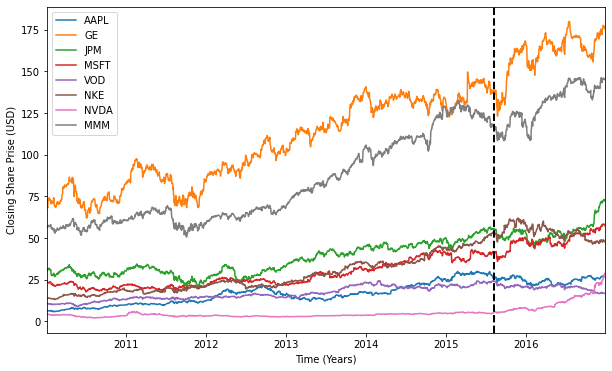

In [8]:
plt.rcParams["figure.figsize"] = (10,6)
for i in tickers:
    plt.plot(data[i], label=i)

# only one line may be specified; full height
plt.axvline(pd.to_datetime('2015-08-10'), color='black', linestyle='--', lw=2)
plt.legend()
plt.margins(x=0)
plt.ylabel("Closing Share Prise (USD)")
plt.xlabel("Time (Years)")
plt.savefig('data0.png',bbox_inches='tight')

# -----------------------------------------------
# ----------------------------------------------- 

# Evaluating models

## Deep Reinfrocement Learning

In [ ]:
#!pip install deep-rl
#!pip install stable-baselines3

In [ ]:
import numpy as np
import random
from deepRL import StockEnvTrade, train, DRL_prediction
from stable_baselines3.common.vec_env import DummyVecEnv

In [ ]:
rebalance_period = 1
re_df = data.iloc[::rebalance_period, :]
train_re_df = data_train.iloc[::rebalance_period, :]
test_re_df = data_test.iloc[::rebalance_period, :]

In [ ]:
timesteps = 25000
runs = 10
policy = "MlpPolicy"
length = test_re_df.shape[0]
stocks = test_re_df.shape[1]

### PPO

In [ ]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo = np.zeros([runs, length])
portfolio_weights_ppo = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ppo[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ppo[i])
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo[i]),axis=1)
    Cumulative_returns_daily_drl_ppo[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

ppo_mean = np.mean(np.array(Cumulative_returns_daily_drl_ppo),axis=0)
ppo_std = np.std(np.array(Cumulative_returns_daily_drl_ppo),axis=0)

axs[0,0].plot(test_re_df.index, ppo_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, ppo_mean - ppo_std, ppo_mean + ppo_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = np.mean(np.array(portfolio_weights_ppo),axis=0)
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

### A2C

In [ ]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c = np.zeros([runs, length])
portfolio_weights_a2c = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_a2c[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_a2c[i]) 
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c[i]),axis=1)
    Cumulative_returns_daily_drl_a2c[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

a2c_mean = np.mean(np.array(Cumulative_returns_daily_drl_a2c),axis=0)
a2c_std = np.std(np.array(Cumulative_returns_daily_drl_a2c),axis=0)

axs[0,0].plot(test_re_df.index, a2c_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, a2c_mean - a2c_std, a2c_mean + a2c_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = np.mean(np.array(portfolio_weights_a2c),axis=0)
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

### DDPG

In [ ]:
algo = "DDPG"
Cumulative_returns_daily_drl_ddpg = np.zeros([runs, length])
portfolio_weights_ddpg = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ddpg[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ddpg[i]) 
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg[i]),axis=1)
    Cumulative_returns_daily_drl_ddpg[i] = (1+return_stocks_ddpg).cumprod()
    i = i+1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

ddpg_mean = np.mean(np.array(Cumulative_returns_daily_drl_ddpg),axis=0)
ddpg_std = np.std(np.array(Cumulative_returns_daily_drl_ddpg),axis=0)

axs[0,0].plot(test_re_df.index, ddpg_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, ddpg_mean - ddpg_std, ddpg_mean + ddpg_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ddgpc_ = np.mean(np.array(portfolio_weights_ddpg),axis=0)
df = pd.DataFrame (portfolio_weights_ddgpc_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_ddgpc_ = portfolio_weights_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
df = pd.DataFrame (portfolio_weights_ddgpc_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ddgpc_ = portfolio_weights_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
df = pd.DataFrame (portfolio_weights_ddgpc_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

### SAC

In [ ]:
algo = "SAC"
Cumulative_returns_daily_drl_sac = np.zeros([runs, length])
portfolio_weights_sac = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_sac[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_sac[i]) 
    cont = cont +1
    if check != length:
        continue
    
    return_stocks = test_re_df.pct_change()
    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac[i]),axis=1)
    Cumulative_returns_daily_drl_sac[i] = (1+return_stocks_sac).cumprod()
    i = i+1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

sac_mean = np.mean(np.array(Cumulative_returns_daily_drl_sac),axis=0)
sac_std = np.std(np.array(Cumulative_returns_daily_drl_sac),axis=0)

axs[0,0].plot(test_re_df.index, sac_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, sac_mean - sac_std, sac_mean + sac_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = np.mean(np.array(portfolio_weights_sac),axis=0)
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = portfolio_weights_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = portfolio_weights_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

### TD3

In [ ]:
algo = "TD3"
Cumulative_returns_daily_drl_td3 = np.zeros([runs, length])
portfolio_weights_td3 = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_td3[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_td3[i])
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3[i]),axis=1)
    Cumulative_returns_daily_drl_td3[i] = (1+return_stocks_td3).cumprod()
    i = i+1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

td3_mean = np.mean(np.array(Cumulative_returns_daily_drl_td3),axis=0)
td3_std = np.std(np.array(Cumulative_returns_daily_drl_td3),axis=0)

axs[0,0].plot(test_re_df.index, td3_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, td3_mean - td3_std, td3_mean + td3_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_td3_ = np.mean(np.array(portfolio_weights_td3),axis=0)
df = pd.DataFrame (portfolio_weights_td3_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_td3_ = portfolio_weights_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
df = pd.DataFrame (portfolio_weights_td3_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_td3_ = portfolio_weights_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
df = pd.DataFrame (portfolio_weights_td3_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

## Traditional approaches

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import riskfolio as rp

In [ ]:
# working days in a year 252
window = 50
start = len(train_re_df)-window
data = re_df.iloc[start:]
data = data.reset_index(drop=True)

### Min-Variance Portfolio Allocation

In [ ]:
portfolio_weights_min_var = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_var.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)
    
    try:
        weights = ef.max_sharpe()
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )

    portfolio_weights_min_var[idx]=np.array([weights[j] for j in tickers])
    idx +=1

In [ ]:
return_stocks = test_re_df.pct_change()
return_stocks_min_var = np.sum(return_stocks.multiply(portfolio_weights_min_var),axis=1)
Cumulative_returns_daily_min_var = (1+return_stocks_min_var).cumprod()
plt.plot(Cumulative_returns_daily_min_var)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [ ]:
df = pd.DataFrame (portfolio_weights_min_var, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

### Min volatility

In [ ]:
portfolio_weights_min_vol = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_vol.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)  
    weights = ef.min_volatility() 
   
    portfolio_weights_min_vol[idx]=np.array([weights[j] for j in tickers])
    idx +=1

In [ ]:
return_stocks_min_vol = np.sum(return_stocks.multiply(portfolio_weights_min_vol),axis=1)
Cumulative_returns_daily_min_vol = (1+return_stocks_min_vol).cumprod()
plt.plot(Cumulative_returns_daily_min_vol)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [ ]:
df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

### Risk Parity

In [ ]:
portfolio_weights_risk = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_risk.shape[0]):    
    sel = data.iloc[i:window+i]
   
    # Building the portfolio object
    port = rp.Portfolio(returns=sel)

    # Calculating optimal portfolio
    # Select method and estimate input parameters:
    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    model='Classic' # Could be Classic (historical) or FM (Factor Model)
    rm = 'MV' # Risk measure used, this time will be variance
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    b = None # Risk contribution constraints vector
    weights = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)
   
    portfolio_weights_risk[idx]=np.squeeze(np.array(weights))
    idx +=1  

In [ ]:
return_stocks = test_re_df.pct_change()
return_stocks_risk = np.sum(return_stocks.multiply(portfolio_weights_risk),axis=1)
Cumulative_returns_daily_risk = (1+return_stocks_risk).cumprod()
plt.plot(Cumulative_returns_daily_risk)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [ ]:
df = pd.DataFrame (portfolio_weights_risk, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

### Equal weighting

In [ ]:
portfolio_weights_equal = np.ones([test_re_df.shape[0],test_re_df.shape[1]])/test_re_df.shape[1]

In [ ]:
return_stocks = test_re_df.pct_change()
return_stocks_equal = np.sum(return_stocks.multiply(portfolio_weights_equal),axis=1)
Cumulative_returns_daily_equal = (1+return_stocks_equal).cumprod()
plt.plot(Cumulative_returns_daily_equal)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [ ]:
df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

df = pd.DataFrame (portfolio_weights_min_var, index = test_re_df.index, columns = tickers)
axs[0,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'])
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].set_ylabel("Weights (%)")
axs[0,0].set_xlabel("Time (Years-Months)")

df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

df = pd.DataFrame (portfolio_weights_risk, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'])
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'])
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")


plt.savefig('traditional0.png',bbox_inches='tight')

## Plotting all cumulative returns mtogether

In [ ]:
x = Cumulative_returns_daily_equal.index.values

plt.plot(x, Cumulative_returns_daily_min_var, color='tab:olive', label="Tangent Portfolio", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_min_vol, color='tab:gray', label="Minimum Volatility", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_risk, color='tab:green', label="Risk Parity", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_equal, color='tab:red', label="Equal Weight", linewidth =2.0)

a2c = Cumulative_returns_daily_drl_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = Cumulative_returns_daily_drl_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = Cumulative_returns_daily_drl_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = Cumulative_returns_daily_drl_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = Cumulative_returns_daily_drl_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)

plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_max0.png',bbox_inches='tight')

In [ ]:
x = Cumulative_returns_daily_equal.index.values

plt.plot(x, Cumulative_returns_daily_min_var, color='tab:olive', label="Tangent Portfolio", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_min_vol, color='tab:gray', label="Minimum Volatility", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_risk, color='tab:green', label="Risk Parity", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_equal, color='tab:red', label="Equal Weight", linewidth =2.0)

a2c = Cumulative_returns_daily_drl_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = Cumulative_returns_daily_drl_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = Cumulative_returns_daily_drl_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = Cumulative_returns_daily_drl_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = Cumulative_returns_daily_drl_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)

plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_min0.png',bbox_inches='tight')

In [ ]:
portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_),axis=1)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_),axis=1)

portfolio_weights_ddpg_ = portfolio_weights_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg_),axis=1)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_),axis=1)

portfolio_weights_td3_ = portfolio_weights_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3_),axis=1)

In [ ]:
portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_),axis=1)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_),axis=1)

portfolio_weights_ddpg_ = portfolio_weights_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg_),axis=1)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_),axis=1)

portfolio_weights_td3_ = portfolio_weights_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3_),axis=1)

In [ ]:
return_stocks_ppo
return_stocks_a2c
return_stocks_ddpg
return_stocks_sac
return_stocks_td3
return_stocks_min_var
return_stocks_min_vol
return_stocks_risk
return_stocks_equal
print("")

## Other statistics

In [ ]:
import pyfolio

In [ ]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_ppo, set_context=False)